# Air Transportation Network Prediction Using GraphStorm

This demonstration notebook provides the end-to-end training and inference pipelines for the air transportation network prediction. For this synthetic air transportation network data, we define the prediction task as a node time series regression, i.e., predicting the total inventory amount.

Users may find that the end-to-end pipelines built in this notebook are similar as the [Notebook 1: Use GraphStorm APIs for Building a Node Classification Pipeline](https://graphstorm.readthedocs.io/en/latest/api/notebooks/Notebook_1_NC_Pipeline.html). This notebook, however, has three major differences from the Notebook 1 API example, including:

1. A customized RGCN model that can use sliding window method to process time series data for regression;
2. A customized node trainer class that can handle the specific evaluation method for time series data;
3. A customized node inferrer class that can handle the autoagressive sliding window method during model inference.

In [1]:
# Setup log level in Jupyter Notebook to show running information
import logging
logging.basicConfig(level=20)

---

### 0. Initialize the GraphStorm Standalone Environment

The first step to use GraphStorm is to call `gs.initialize()` for the Standalone mode.

In [2]:
# Define the total days, should be same as data generation
NUM_DEMAND_DAYS = 31

# initialization
import graphstorm as gs
gs.initialize()

/opt/conda/envs/gsf/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/opt/conda/envs/gsf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/gsf/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Initialize the distributed services with graphbolt: False


/opt/conda/envs/gsf/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/envs/gsf/lib/python3.10/site-packages/dgl/distributed/dist_context.py:248: DGLWarning: net_type is deprecated and will be removed in future release.
  dgl_warning(


### 1. Setup GraphStorm Dataset and DataLoaders

Similar as Pytorch model training pipeline, we create a dataset by constructing `gs.dataset.GSgnnData` class. In most cases, users only need to provide the location of the graph description JSON file, which is created in GraphStorm's gconstruct operation.

In [3]:
# create a GraphStorm Dataset for the movie_lens graph data generated with GraphStorm test code
from graphstorm.dataloading import GSgnnData

ml_data = GSgnnData(part_config='./gs_1p/air_traffic.json')

INFO:root:Start to load partition from ./gs_1p/part0/graph.dgl which is 6677929 bytes. It may take non-trivial time for large partition.
INFO:root:Finished loading partition from ./gs_1p/part0/graph.dgl.
INFO:root:Finished loading node data.
INFO:root:Finished loading edge data.


Then, we create different `DataLoader`s for training, validation, and testing. As shown below, we allow users to specify different `DataLoader` settings, e.g., `fanout`, `batch_size`, except for a few model-related properties, such as `node_feats`, `edge_feats` and `label_field`.

GNN models may only use parts of graph features, therefore, GraphStorm `DataLoader`s allow users to specifies the `node_feats` and `edge_feats` in the format of a dictionary of lists of strings. Keys of the dictionary are node type names, while values are lists of feature name strings.

In our synthetic air transportation network, we have both node features and edge features. Below we put them into two dictionaries.

In [4]:
from graphstorm.dataloading import GSgnnNodeDataLoader

# define dataloaders for training, validation, and testing
nfeats_4_modeling = {'airport':['latitude','longitude', 'inventory_amounts']}
efeats_4_modeling = {('airport', 'demand', 'airport'): ['demands'], \
                     ('airport', 'traffic', 'airport'): ['capacity', 'traffics']}
fanout=[10, 10]
train_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_train_set(ntypes=['airport']),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=True)
val_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_val_set(ntypes=['airport']),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=False)
test_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_test_set(ntypes=['airport']),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=False)

INFO:root:part 0, train 376
INFO:root:part 0, val 47
INFO:root:part 0, test 47


### 2. Create a Customized GraphStorm-compatible RGCN Model for the Time Series Node Regression

GraphStorm has a set of GNN component modules that could be freely combined for different tasks. This notebook depends on an RGCN model, `RgcnNRModel4TS`, that extends from the `GSgnnModel` and implements the sliding window method in its `forward()` and `predict()` function for node regression by using GaphStorm model APIs. Users can find the details in the `nr_models.py` file.

Because our synthetic air transportation network have both static features and time series features, the customized `RgcnNRModel4TS` need to know which features are static or time series. So the `RgcnNRModel4TS` asks this information in its arguments.

In [5]:
from nr_models import RgcnNRModel4TS

# initialize the model with specific time series related arugments
ts_nfeat_names = {'airport':['inventory_amounts']}
ts_efeat_names = {('airport', 'demand', 'airport'): ['demands'], \
                  ('airport', 'traffic', 'airport'): ['traffics']}

# import a simplified RGCN model for node classification
model = RgcnNRModel4TS(
    g=ml_data.g,
    num_hid_layers=len(fanout),
    node_feat_field=nfeats_4_modeling,
    edge_feat_field=efeats_4_modeling,
    edge_feat_mp_op='add',
    target_ntype='airport',
    ts_nfeat_names=ts_nfeat_names,
    ts_efeat_names=ts_efeat_names,
    hid_size=128,
    ts_size=NUM_DEMAND_DAYS,
    window_size=7)

ImportError: cannot import name 'GSEdgeEncoderInputLayer' from 'graphstorm.model' (/data/graphstorm/python/graphstorm/model/__init__.py)

### 3. Setup a GraphStorm Evaluator

To check the performance during model training, GraphStorm relies on a set of built-in `Evaluator`s for different tasks. Here we create a `GSgnnRegressionEvaluator` for the node time series regression task.

In [7]:
# setup a classification evaluator for the trainer
from graphstorm.eval import GSgnnRegressionEvaluator

evaluator = GSgnnRegressionEvaluator(eval_frequency=1000)

### 4. Setup a Trainer and Training

For training loop, GraphStorm has different `Trainer`s for specific tasks. GraphStorm's `GSgnnNodePredictionTrainer` is designed to orchestrate dataloaders, models, and evaluators, but cannot handle the sliding window mehtod. So here we extends the `GSgnnNodePredictionTrainer`, replacing its default `node_mini_batch_gnn_predict()` method with a customized method that supports sliding window method for model training and validation, and autoregressive sliding window for inference.  Users can find the details in the `nr_models.py` file.

Then we use the customized trainer's `fit()` to train our model. During training, users can check the output log, finding training loss, evaluation metrics, and etc.

In [8]:
from nr_models import NodePredictionTrainer4TS

# define a trainer, which is our own customized trainer
trainer = NodePredictionTrainer4TS(model)

trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=100,
            save_model_frequency=1000,
            save_model_path='./models/')

INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 139596320.0000 | Time: 0.2803
INFO:root:Epoch 0 take 1.508 seconds
INFO:root:Step 6 | Validation rmse: 1286.3737
INFO:root:Step 6 | Test rmse: 1327.1274
INFO:root:Step 6 | Best Validation rmse: 1286.3737
INFO:root:Step 6 | Best Test rmse: 1327.1274
INFO:root:Step 6 | Best Iteration rmse: 6.0000
INFO:root: Eval time: 0.2847, Evaluation step: 6.
INFO:root:successfully save the model to ./models/epoch-0
INFO:root:Time on save model: 0.002 seconds
INFO:root:Part 0 | Epoch 00001 | Batch 000 | Loss: 1579800.0000 | Time: 0.2429
INFO:root:Epoch 1 take 1.454 seconds
INFO:root:Step 12 | Validation rmse: 447.0486
INFO:root:Step 12 | Test rmse: 468.8462
INFO:root:Step 12 | Best Validation rmse: 447.0486
INFO:root:Step 12 | Best Test rmse: 468.8462
INFO:root:Step 12 | Best Iteration rmse: 12.0000
INFO:root: Eval time: 0.2857, Evaluation step: 12.
INFO:root:successfully save the model to ./models/epoch-1
INFO:root:Time on save model: 0.002 seconds
I

### 5. Visualize Model Performance History

Besides the log, we can examine the model performance on the validation, and testing by visualizing evalutors' history properties.

INFO:matplotlib.font_manager:generated new fontManager


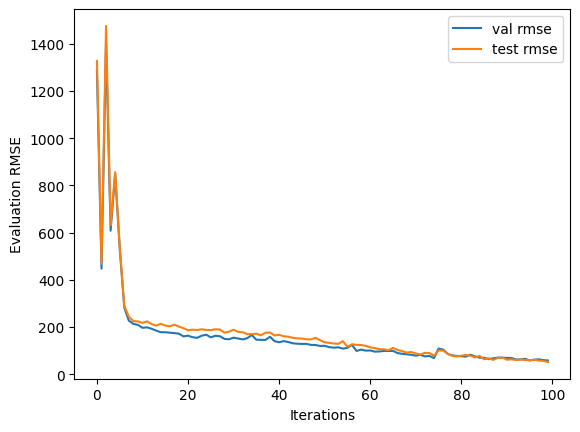

In [9]:
import matplotlib.pyplot as plt

# extract evaluation history of metrics from the evaluator's history property
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['rmse'])
    test_metrics.append(test_metric['rmse'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val rmse')
ax.plot(test_metrics, label='test rmse')
ax.set(xlabel='Iterations', ylabel='Evaluation RMSE')
ax.legend(loc='best')

### 6. Inference with the Trained Model

GraphStorm automatically save the best performed model according to the value specified in the `save_model_path` argument. We can first find out what is the best model and its path. And then restore it by using model's `restore_model()` method.

In [10]:
# after training, the best model is saved to disk
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

# we can restore the model from the saved path using the model's restore_model() function.
model.restore_model(best_model_path)

INFO:root:successfully load the model from ./models/epoch-95
INFO:root:Time on load model: 0.004 seconds


Best model path: ./models/epoch-95


To do inference, users can either create a new dataloader as the following code does, or reuse one of the dataloaders defined in training.

In [11]:
# Setup dataloader for inference
print(f'========================== Do Inference ================================')
infer_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_infer_set(ntypes='airport', mask=None),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=False)

INFO:root:airport does not contains NoneWe will do inference on the entire node set.


========================== Do Inference ================================


GraphStorm provides a set of `Inferrer`s that can perform highly efficient inference for very large graphs. GraphStorm's `GSgnnNodePredictionInferrer` cannot handle the sliding window mehtod either. Similarly we extends the `GSgnnNodePredictionInferrer`, and specifically implements the autoregressive sliding window method by replacing true time serie values with the predicted ones, and then call the same customized `node_mini_batch_gnn_predict()` method during inference.

In [12]:
from nr_models import NodePredictionInferrer4TS

# Run inference on the inference dataset
infer = NodePredictionInferrer4TS(model)

infer.infer(infer_dataloader,
            use_mini_batch_infer=True,
            save_embed_path=None,
            node_id_mapping_file='./gs_1p/node_mapping.pt',
            save_prediction_path='./predictions')

Now let's check the prediction results

In [13]:
# The GNN embeddings and predictions on the inference graph are saved to the folder named after the target_ntype
!ls -lh ./predictions/airport/

total 36K
-rw-rw-r-- 1 ubuntu ubuntu  27K Nov 20 19:19 predict-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu 4.9K Nov 20 19:19 predict_nids-00000.pt
